In [33]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import plotly.graph_objs as go
import matplotlib.pyplot as plt


# from google.colab import drive
# from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFE

# drive.mount('/content/drive')
# os.chdir('//content/drive/MyDrive/1. Educ/3. Masters/Year 1/ICS5110 - Applied Machine Learning/1. Personal Assignment/Git Repo/applied_ml_assignment')
# print(os.getcwd())



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\spichr01\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\spichr01\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


  Obtaining dependency information for notebook from https://files.pythonhosted.org/packages/f3/2b/b904c57709b83c6cbd818d21040db36719207f3d17db9b124c60cd483d94/notebook-7.0.6-py3-none-any.whl.metadata
  Obtaining dependency information for jupyter-server<3,>=2.4.0 from https://files.pythonhosted.org/packages/6e/79/178c7a551d50734a779b1fb7688089e46c6141d8b108b2c9cbb028c27437/jupyter_server-2.11.0-py3-none-any.whl.metadata
  Obtaining dependency information for jupyterlab-server<3,>=2.22.1 from https://files.pythonhosted.org/packages/a2/97/abbbe35fc67b6f9423309988f2e411f7cb117b08321866d3d8b720f4c0d4/jupyterlab_server-2.25.2-py3-none-any.whl.metadata
  Obtaining dependency information for jupyterlab<5,>=4.0.2 from https://files.pythonhosted.org/packages/a7/f2/b3ed35a9d75c22c7a90dc51963e57373d000007ba3ccbfc6277ba6448aa8/jupyterlab-4.0.9-py3-none-any.whl.metadata
  Obtaining dependency information for anyio>=3.1.0 from https://files.pythonhosted.org/packages/36/55/ad4de788d84a630656ece71059

ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\spichr01\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [17]:
#Loading cleaned data from CVS
training_data = pd.read_csv("data/train_data.csv")
test_data = pd.read_csv("data/test_data.csv")
# validation_data = pd.read_csv("data/validate_data.csv")

display(training_data.head(5))

,Date,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,powerplants_c02_kt,GDP_bln,Population_k,tmin,tavg,tmax
0,2003-01-01,0.36,182.08,0.0,0.0,0.0,4.8200,398.580000,10.9,13.2,15.6
1,2003-02-01,0.40,187.10,0.0,0.0,0.0,4.8275,398.580000,7.9,10.4,13.0
2,2003-03-01,0.34,176.37,0.0,0.0,0.0,4.8350,398.804167,9.8,12.7,15.7
3,2003-04-01,0.30,156.53,0.0,0.0,0.0,4.8425,399.028333,12.4,15.5,18.7
4,2003-05-01,0.28,163.97,0.0,0.0,0.0,4.8500,399.252500,16.0,20.4,24.8


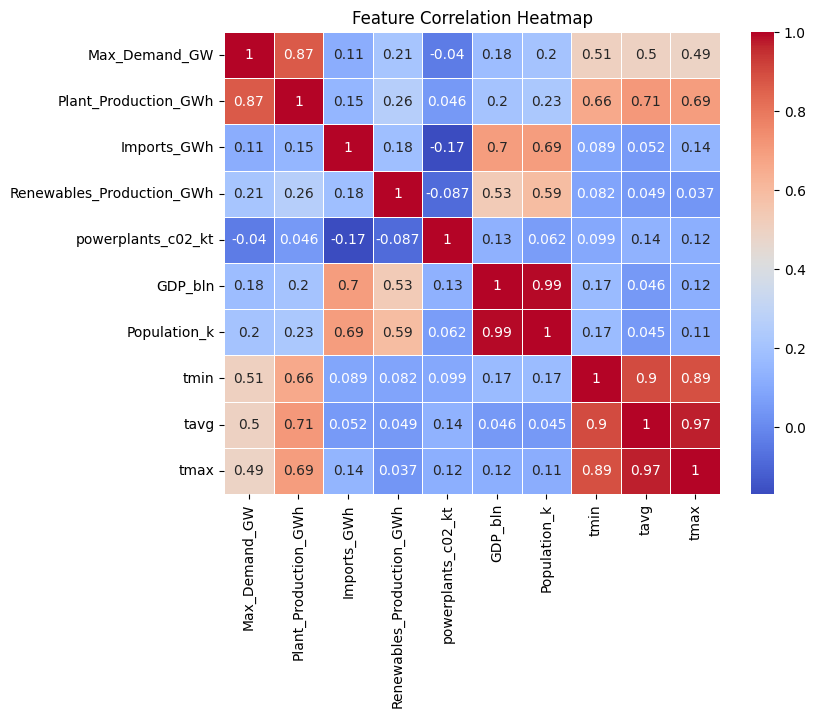

In [19]:
#Building correlation matrices to understand dataset and features
featuresToDrop = ['Date']
correlation_matrix = training_data.drop(columns=featuresToDrop).corr()

# Plot a heatmap of the correlation matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Feature Correlation Heatmap')
plt.show()

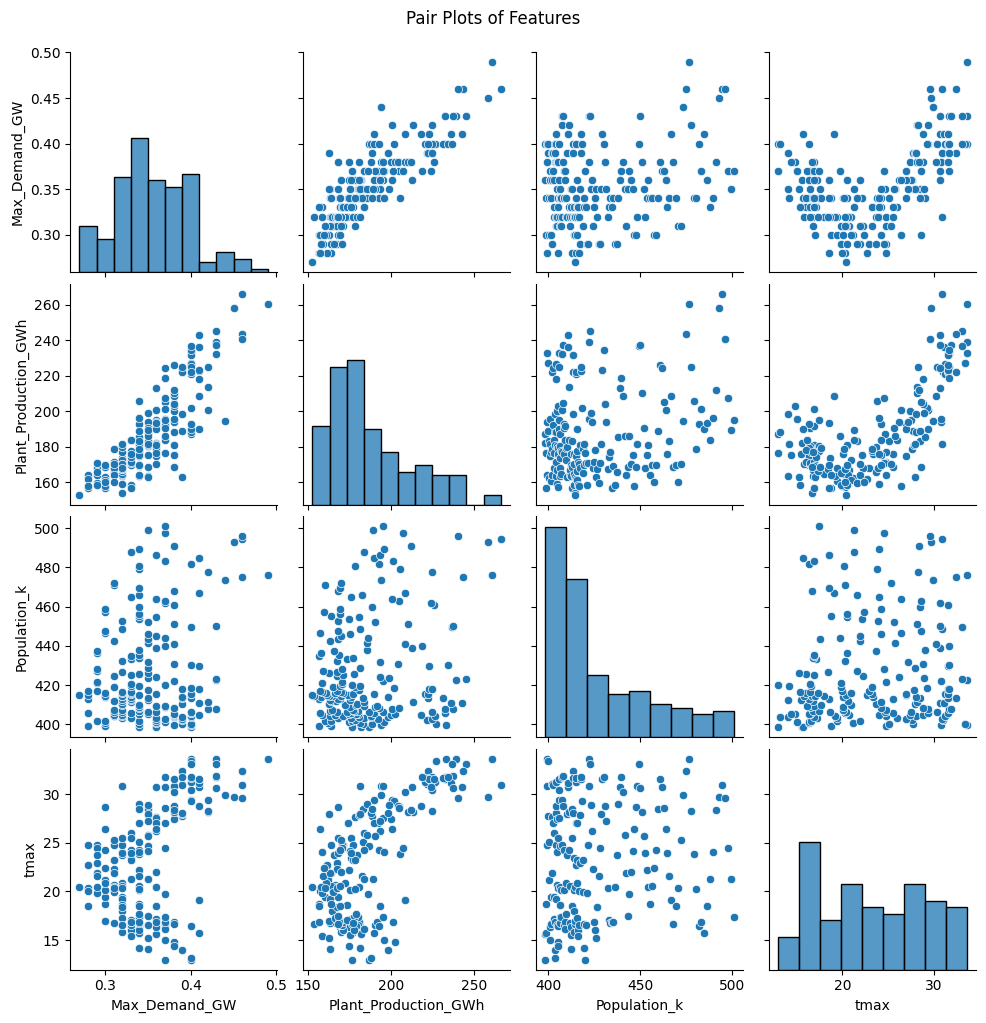

In [11]:
# Extract features excluding the below items
featuresToDrop = ['GDP_bln', 'tmin', 'tavg', 'powerplants_c02_kt', 'Renewables_Production_GWh','Imports_GWh']
datasetToPlot = training_data.drop(columns=featuresToDrop)
selected_features = datasetToPlot.columns[1:]

# Create pair plots using Seaborn
sns.pairplot(training_data[selected_features])
plt.suptitle('Pair Plots of Features', y=1.02)
plt.show()


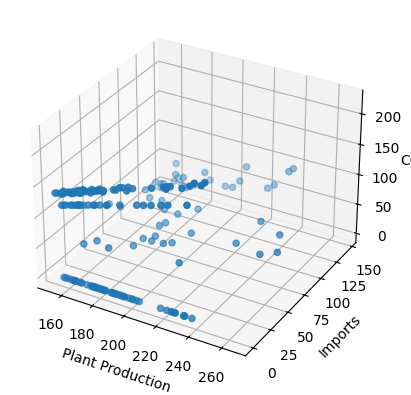

In [20]:
#Analyzing CO2 vs Production vs Imports
# Creating the 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = training_data['Plant_Production_GWh']
y = training_data['Imports_GWh']
z = training_data['powerplants_c02_kt']

# # Scatter plot
ax.scatter(x, y, z)
# ax.view_init(elev=30, azim=120)

# # Set labels
ax.set_xlabel('Plant Production')
ax.set_ylabel('Imports')
ax.set_zlabel('CO2')
# Show plot
plt.show()


In [ ]:
# Create a Plotly trace for a 3D scatter plot
trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=z,  # Color by z-value for example
        colorscale='Viridis',  # Choose a colorscale
        opacity=0.8
    )
)

# Create the layout for the plot
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='Plant Production'),
        yaxis=dict(title='Imports'),
        zaxis=dict(title='CO2')
    )
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Display the interactive plot
fig.show()

In [ ]:
# Create a Plotly trace for a 3D scatter plot
trace = go.Scatter3d(
    x=training_data['tmax'],
    y=training_data['Population_k'],
    z=training_data['Max_Demand_GW'],
    mode='markers',
    marker=dict(
        size=5,
        color=z,  # Color by z-value for example
        colorscale='Viridis',  # Choose a colorscale
        opacity=0.8
    )
)

# Create the layout for the plot
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='tmax'),
        yaxis=dict(title='population'),
        zaxis=dict(title='max_demand')
    )
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Display the interactive plot
fig.show()

In [23]:
selectedFeatures = ['tmax', 'Population_k']
selectedTarget = ['Max_Demand_GW']

x_ToTrain = training_data[selectedFeatures]
y_ToTrain = training_data[selectedTarget]

x_ToTest = test_data[selectedFeatures]
y_ToTest = test_data[selectedTarget]

x_ToTrain = x_ToTrain.to_numpy()
y_ToTrain = y_ToTrain.to_numpy().ravel()

# x_ToTest = x_ToTrain.to_numpy()
# y_ToTest = y_ToTest.to_numpy().ravel()


svm_regressor = SVR(kernel='rbf')  # You can specify different kernels like 'linear', 'poly', 'rbf', etc.
svm_regressor.fit(x_ToTrain, y_ToTrain)

# Making predictions
y_pred = svm_regressor.predict(x_ToTest)
y_pred_df = pd.DataFrame(data=y_pred)

# display(y_pred_df)
# display(y_ToTest)
# Evaluating the model (example using Mean Squared Error)
mse = mean_squared_error(y_ToTest, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.00520122836066783


C:\Users\spichr01\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but SVR was fitted without feature names



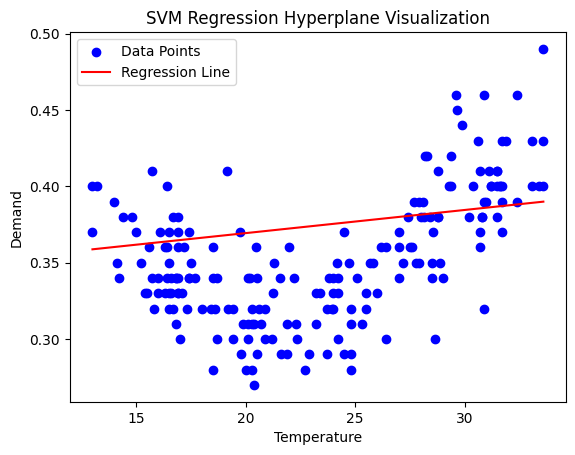

In [24]:
selectedFeatures = ['tmax']
selectedTarget = ['Max_Demand_GW']

x_ToTrain = training_data[selectedFeatures]
y_ToTrain = training_data[selectedTarget]

x_ToTrain = x_ToTrain.to_numpy()
y_ToTrain = y_ToTrain.to_numpy().ravel()

# Creating and fitting the SVM regression model
svm = SVR(kernel='linear', C=1.0)
svm.fit(x_ToTrain, y_ToTrain)

# Get the weights and bias term
w = svm.coef_[0]
b = svm.intercept_[0]

# Plotting the data points
plt.scatter(x_ToTrain, y_ToTrain, c='blue', label='Data Points')

# Plotting the hyperplane
x_values = np.linspace(np.min(x_ToTrain), np.max(x_ToTrain), 100)
y_values = w * x_values + b

plt.plot(x_values, y_values, color='red', label='Regression Line')

plt.xlabel('Temperature')
plt.ylabel('Demand')
plt.title('SVM Regression Hyperplane Visualization')
plt.legend()
plt.show()

Gamma Range:
Small Gamma:

gamma < 1: A smaller gamma implies a larger range of influence for each support vector. The decision boundary tends to be smoother, and the model might generalize better.
Large Gamma:

gamma > 1: A larger gamma shrinks the range of influence of support vectors, making the decision boundary more 'wiggly' to fit closely to individual data points.
gamma = 'auto' or 'scale': In scikit-learn, 'auto' or 'scale' settings automatically set the value of gamma. 'auto' uses 1/n_features, and 'scale' uses 1/(n_features * X.var()).
Impact:
Higher gamma: Can lead to overfitting, especially with smaller datasets or noisy data, as the model might adapt too closely to the training data.
Lower gamma: Tends to produce smoother decision boundaries, aiding in better generalization to unseen data.



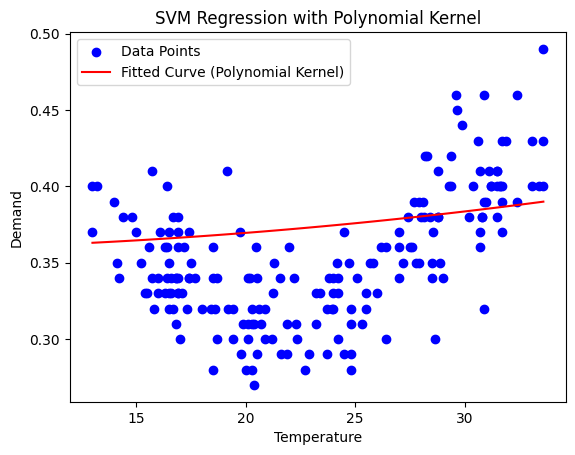

In [25]:
selectedFeatures = ['tmax']
selectedTarget = ['Max_Demand_GW']

x_poly = training_data[selectedFeatures]
y_poly = training_data[selectedTarget]

x_poly = x_poly.to_numpy()
y_poly = y_poly.to_numpy().ravel()

# Creating and fitting the SVM regression model with a polynomial kernel
svm_poly = SVR(kernel='poly', degree=2, C=10, gamma='auto')
svm_poly.fit(x_poly, y_poly)

# Plotting the data points
plt.scatter(x_poly, y_poly, c='blue', label='Data Points')

# Plotting the predicted curve
x_values = np.linspace(np.min(x_poly), np.max(x_poly), 100)
y_values = svm_poly.predict(x_values.reshape(-1, 1))  # Reshaping for prediction

plt.plot(x_values, y_values, color='red', label='Fitted Curve (Polynomial Kernel)')

plt.xlabel('Temperature')
plt.ylabel('Demand')
plt.title('SVM Regression with Polynomial Kernel')
plt.legend()
plt.show()

**Normalizing**

**Standardization (Z-score normalization):**
Method: Subtract the mean and scale by the standard deviation for each feature.
Benefits: Useful when features have different units or different ranges.

**Min-Max Scaling (Normalization):**
Method: Scale features to a specific range, often [0, 1].
Benefits: Useful when algorithms require inputs to be in a specific range.

**Robust Scaling:**
Method: Scale features using median and interquartile range (IQR) to make them robust to outliers.
Benefits: Useful when data contains outliers.

**Log Transformation:**
Method: Apply logarithmic transformation to the data to handle skewed distributions or to emphasize relative changes.
Benefits: Useful when the data is heavily skewed.

**Which to Choose:**
Use standardization (StandardScaler in scikit-learn) when features have varying scales and roughly Gaussian-like distributions.
Use min-max scaling (MinMaxScaler in scikit-learn) when the algorithm requires input in a specific range.
Use robust scaling (RobustScaler in scikit-learn) when the dataset contains outliers.
Use log transformation if the data has a heavily skewed distribution.


ChatGPT

In [26]:
selectedFeatures = ['tmax']
selectedTarget = ['Max_Demand_GW']

x = training_data[selectedFeatures]
y_norm = training_data[selectedTarget]

scaler = StandardScaler()  # Or use MinMaxScaler, RobustScaler, etc.
x_norm= scaler.fit_transform(x)
y_norm = y_norm.to_numpy().ravel()

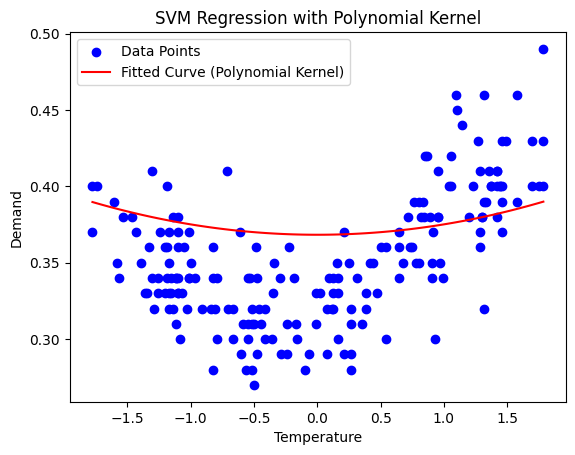

In [27]:
# Creating and fitting the SVM regression model with a polynomial kernel
svm_poly_norm = SVR(kernel='poly', degree=2, C=10, gamma='auto') #can use scale
svm_poly_norm.fit(x_norm, y_norm)

# Plotting the data points
plt.scatter(x_norm, y_norm, c='blue', label='Data Points')

# Plotting the predicted curve
x_values = np.linspace(np.min(x_norm), np.max(x_norm), 100)
y_values = svm_poly_norm.predict(x_values.reshape(-1, 1))  # Reshaping for prediction

plt.plot(x_values, y_values, color='red', label='Fitted Curve (Polynomial Kernel)')

plt.xlabel('Temperature')
plt.ylabel('Demand')
plt.title('SVM Regression with Polynomial Kernel')
plt.legend()
plt.show()

C:\Users\spichr01\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but SVR was fitted without feature names

C:\Users\spichr01\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but SVR was fitted without feature names

C:\Users\spichr01\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but SVR was fitted without feature names

C:\Users\spichr01\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but SVR was fitted without feature names



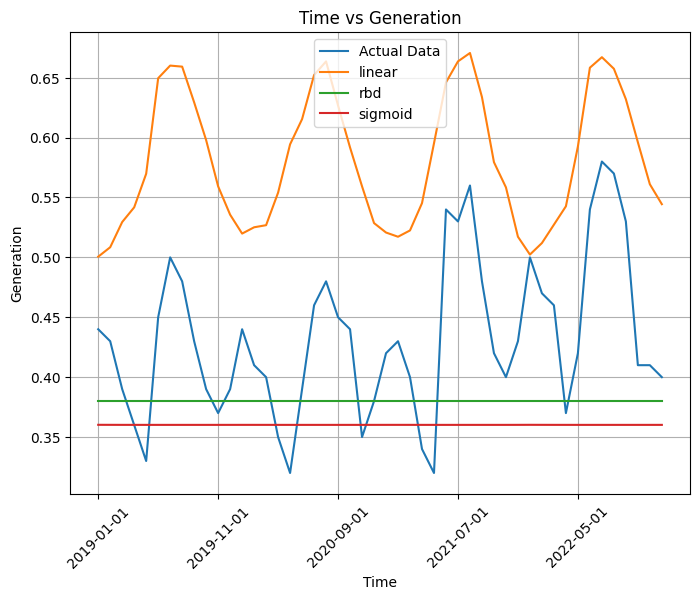

In [57]:
selectedFeatures = ['tmax']
selectedTarget = ['Max_Demand_GW']

x_Time = test_data['Date']
y_Test = test_data[selectedTarget]

model_linear = SVR(kernel='linear')
model_linear.feature_names = selectedFeatures
model_linear.fit(x_norm, y_norm)
y_pred_linear = model_linear.predict(x_ToTest)


# model_poly = SVR(kernel='poly', degree=2, C=1, gamma='auto') 
model_poly = SVR(kernel='poly', degree=1) 
model_poly.feature_names = selectedFeatures
model_poly.fit(x_norm, y_norm)
y_pred_poly = model_poly.predict(x_ToTest)


model_rbf = SVR(kernel='rbf', gamma='scale')  # Using RBF kernel with default gamma
model_rbf.feature_names = selectedFeatures
model_rbf.fit(x_norm, y_norm)
y_pred_rbf = model_rbf.predict(x_ToTest)

model_sigmoid = SVR(kernel='sigmoid', gamma='scale')  # Using a sigmoid kernel
model_sigmoid.feature_names = selectedFeatures
model_sigmoid.fit(x_norm, y_norm)
y_pred_sigmoid = model_sigmoid.predict(x_ToTest)

# Plotting the feature vs target curve
plt.figure(figsize=(8, 6))
plt.plot(x_Time, y_Test, linestyle='-', label="Actual Data")
plt.plot(x_Time, y_pred_linear, linestyle='-', label="linear")
# plt.plot(x_Time, y_pred_poly, linestyle='-', label = "poly")
plt.plot(x_Time, y_pred_rbf, linestyle='-', label = "rbd")
plt.plot(x_Time, y_pred_sigmoid, linestyle='-', label="sigmoid")

n = 10
plt.xticks(np.arange(0, len(x_Time), n), [x_Time[i] for i in range(0, len(x_Time), n)])

plt.title('Time vs Generation')
plt.xticks(rotation=45) 
plt.xlabel('Time')
plt.ylabel('Generation')
plt.grid(True)
plt.legend()
plt.show()

 SelectFromModel using an SVR (Support Vector Regression) model with importance_getter='auto' - the feature selector is expecting the underlying estimator (in this case, the SVR model) to have either coef_ or feature_importances_ attribute available for feature selection.

**In the case of SVR, it doesn't have a coef_ attribute by default, as it doesn't provide direct coefficients like linear regression. SVR relies on support vectors, not coefficients, for prediction.**

To resolve:

Selecting an Attribute Manually:

Specify the attribute explicitly using importance_getter to access specific properties from the SVR model. For instance, you could set importance_getter='coef_' if you're looking for coefficients, although SVR doesn't provide direct coefficients.

Use a Different Feature Selector:

Consider using other feature selection methods that are not dependent on coef_ or feature_importances_. For SVR, *Recursive Feature Elimination (RFE)* or Sequential Feature Selection might be more appropriate.
Manually Extracting Feature Importance:

For SVR, calculate or derive feature importance using other techniques specific to the problem domain or by analyzing the support vectors' influence on predictions.

In [ ]:
selectedFeaturesToTest = ['tmax','tmin','tavg', 'Population_k','powerplants_c02_kt', 'Plant_Production_GWh' ]
selectedTargetToTest = ['Max_Demand_GW']

x_getFeatures = training_data[selectedFeaturesToTest]
y_getFeatures = training_data[selectedTargetToTest]

x_getFeatures = x_getFeatures.to_numpy()
y_getFeatures = y_getFeatures.to_numpy().ravel()

svr = SVR(kernel='linear')
svr.fit(x_getFeatures, y_getFeatures)

# Initialize RFE
rfe = RFE(estimator=svr, n_features_to_select=3)  # Choose the number of features you want to select

# Fit RFE
rfe.fit(x_getFeatures, y_getFeatures)

# Selected features
X_selected = rfe.transform(x_getFeatures)
# display(X_selected)

array([[398.58      ,   0.        , 182.08      ],
       [398.58      ,   0.        , 187.1       ],
       [398.80416667,   0.        , 176.37      ],
       [399.02833333,   0.        , 156.53      ],
       [399.2525    ,   0.        , 163.97      ],
       [399.47666667,   0.        , 193.97      ],
       [399.70083333,   0.        , 232.95      ],
       [399.925     ,   0.        , 227.09      ],
       [400.14916667,   0.        , 188.77      ],
       [400.37333333,   0.        , 183.06      ],
       [400.5975    ,   0.        , 162.41      ],
       [400.82166667,   0.        , 181.24      ],
       [401.04583333,   0.        , 195.63      ],
       [401.27      ,   0.        , 174.76      ],
       [401.48333333,   0.        , 176.64      ],
       [401.69666667,   0.        , 160.59      ],
       [401.91      ,   0.        , 163.77      ],
       [402.12333333,   0.        , 178.49      ],
       [402.33666667,   0.        , 221.76      ],
       [402.55      ,   0.     